# K Nearest Neighbor Model

### About KNN


In [14]:
%matplotlib inline

import re
import statsmodels
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV

In [2]:
# Remove white space from around the entries

def pickle(path, object):
    '''
    Dumps the specified object into a picklefile at the specified path
    '''
    with open(path, 'wb') as picklefile:
        pickle.dump(object, picklefile)
        print("Created picklefile of at: " + path)

def open_pickle_df(path, dfdf_name):
    '''
    Opens a picklefile from the specified path
    '''
    with open(path, 'rb') as picklefile: 
        df_name = pickle.load(picklefile)
        return df_name.head()

def strip_entries(df, cols):
    strip = lambda x : x.strip() if type(x) == str else x
    for col in cols:
        df[col] = df[col].apply(strip)

def replace_zeros(df,cols):
    for col in cols:
        df[col] = df[col].replace('="0.00"','0')
        df[col] = df[col].replace('="0"','0')       
        
def remove_misc(df,cols):
    for col in cols:
        df[col] = df[col].replace('="0.75"', np.nan)
        df[col] = df[col].replace('="0.32"', np.nan)
        df[col] = df[col].replace('="0.37"', np.nan)
        df[col] = df[col].replace('="0.99"', np.nan)
        

def cast_as_float(df, cols):
    for col in cols:
        df[col] = df[col].astype(float, copy=False)
        
def cast_as_int(df, cols):
    for col in cols:
        df[col] = df[col].astype(int, copy=False)
        
lower = lambda x : x.lower() if type(x) == str else x

In [3]:
# Import county data

county_df = pd.read_csv('../data/interim/income_by_county.csv')
print(county_df.shape)
county_df.head()

(3195, 6)


,Year,county_id,state_county_name,pct_all_ages_in_poverty,pct_under_18_in_poverty,median_hh_income
0,2015.0,0.0,United States,14.7,20.7,"$55,775"
1,2015.0,1000.0,Alabama,18.5,26.5,"$44,833"
2,2015.0,1001.0,Autauga County (AL),12.7,18.8,"$56,580"
3,2015.0,1003.0,Baldwin County (AL),12.9,19.6,"$52,387"
4,2015.0,1005.0,Barbour County (AL),32.0,45.2,"$31,433"


In [4]:
county_df['median_hh_income'].iloc[1]

'$44,833'

In [5]:
# Strip out spaces around column names
county_df.columns = county_df.columns.map(str.strip)
county_df.columns

Index(['Year', 'county_id', 'state_county_name', 'pct_all_ages_in_poverty',
       'pct_under_18_in_poverty', 'median_hh_income'],
      dtype='object')

In [6]:
county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 6 columns):
Year                       3194 non-null float64
county_id                  3194 non-null float64
state_county_name          3194 non-null object
pct_all_ages_in_poverty    3193 non-null float64
pct_under_18_in_poverty    3193 non-null float64
median_hh_income           3193 non-null object
dtypes: float64(4), object(2)
memory usage: 149.8+ KB


In [7]:
strip_entries(county_df, ['state_county_name'])
# strip = lambda x : x.strip() if type(x) == str else x
# county_df['state_county_name'].apply(strip)

In [8]:
remove_dollar_sign = lambda x : re.sub("[^\d\.]", "", x) if type(x) == str else x
county_df['median_hh_income'] = county_df['median_hh_income'].apply(remove_dollar_sign)

In [9]:
county_df['state_county_name'] = county_df['state_county_name'].apply(lower)

In [10]:
county_df.head()

,Year,county_id,state_county_name,pct_all_ages_in_poverty,pct_under_18_in_poverty,median_hh_income
0,2015.0,0.0,united states,14.7,20.7,55775
1,2015.0,1000.0,alabama,18.5,26.5,44833
2,2015.0,1001.0,autauga county (al),12.7,18.8,56580
3,2015.0,1003.0,baldwin county (al),12.9,19.6,52387
4,2015.0,1005.0,barbour county (al),32.0,45.2,31433


In [11]:
cast_as_float(county_df, ['median_hh_income'])
county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3195 entries, 0 to 3194
Data columns (total 6 columns):
Year                       3194 non-null float64
county_id                  3194 non-null float64
state_county_name          3194 non-null object
pct_all_ages_in_poverty    3193 non-null float64
pct_under_18_in_poverty    3193 non-null float64
median_hh_income           3193 non-null float64
dtypes: float64(5), object(1)
memory usage: 149.8+ KB


In [16]:
with open('../data/processed/0219_county_data_cleaned.pkl', 'wb') as picklefile:
    pickle.dump(county_df, picklefile)

### Import and process elsi public school data

In [17]:
with open('../data/processed/0216_elsi_public_schools.pkl', 'rb') as picklefile: 
    df_public = pickle.load(picklefile)
print(df_public.shape)
df_public.head()

(18114, 59)


,school_name,state_name,state,school_name_cl,school_id,agency_id,county_name,county_number,fips_state_code,school_level_code,...,hawaiian_nat_pacific_isl_students,two_or_more_races_students,total_race_ethnicity,male_students,female_students,agency_type_dis_x,school_type_x,state_school_id_x,congressional_code_x,reconstituted_flag
1,1050 ADAIR CO. HIGH,Missouri,MO,ADAIR CO. HIGH,290579000125,2905790,ADAIR COUNTY,29001,29,3-High,...,"=""0""",2,†,41,51,1-Regular local school district that is NOT a ...,1-Regular school,1050001092,2906,2-No
2,112 ALC AFTER SCHOOL & SUMMER SCH,Minnesota,MN,112 ALC AFTER SCHOOL & SUMMER SCH,270819004415,2708190,CARVER COUNTY,27019,27,3-High,...,"=""0""",1,†,10,2,1-Regular local school district that is NOT a ...,4-Alternative/other school,"=""010112067""",2703,2-No
7,21ST CENTURY ACADEMY,Kentucky,KY,21st Century Academy,210115002241,2101150,CHRISTIAN COUNTY,21047,21,3-High,...,"=""0""",3,†,52,41,1-Regular local school district that is NOT a ...,4-Alternative/other school,"=""024115185""",2101,2-No
14,21ST CENTURY SKILLS ACADEMY,Massachusetts,MA,21st Century Skills Academy,251251002790,2512510,HAMPDEN COUNTY,25013,25,3-High,...,"=""0""","=""0""",†,9,4,1-Regular local school district that is NOT a ...,1-Regular school,"=""03320515""",2501,2-No
15,270 - HAP - IS,Minnesota,MN,270 - HAP - IS,270002504573,2700025,HENNEPIN COUNTY,27053,27,3-High,...,"=""0""","=""0""",†,"=""0""","=""0""",4-Regional Education Service Agency (RESA),4-Alternative/other school,"=""060287794""",2705,2-No


In [18]:
# Strip out spaces around column names
df_public.columns = df_public.columns.map(str.strip)
df_public.columns

Index(['school_name', 'state_name', 'state', 'school_name_cl', 'school_id',
       'agency_id', 'county_name', 'county_number', 'fips_state_code',
       'school_level_code', 'charter_school', 'magnet_school',
       'shared_time_school', 'urban_centric_locale', 'start_of_year_status',
       'agency_type_dis', 'school_type', 'school_wide_title_I',
       'title_I_eligible_school', 'longitude', 'latitude', 'state_school_id',
       'congressional_code', 'virtual_school_status',
       'national_school_lunch_program', 'total_students_all_grades_excl_ae',
       'total_students_all_grades_incl_ae', 'free_lunch_eligible',
       'reduced_price_lunch_eligible_students', 'pupil_teacher_ratio',
       'fte_teachers', 'grade_13_students', 'grade_12_students',
       'grade_11_students', 'grade_10_students', 'grade_9_students',
       'state_name_x', 'school_id_x', 'agency_id_x', 'county_name_x',
       'ansi_fips_state_code', 'address', 'city', 'zip',
       'american_indian_students', 'asian

In [19]:
# df_public['state_county_name'] = df_public['county_name'] + " (" + df_public['state'] + ")"

In [20]:
# df_public['state_county_name'] = df_public['state_county_name'].apply(lower)

In [21]:
df_public.head()

,school_name,state_name,state,school_name_cl,school_id,agency_id,county_name,county_number,fips_state_code,school_level_code,...,two_or_more_races_students,total_race_ethnicity,male_students,female_students,agency_type_dis_x,school_type_x,state_school_id_x,congressional_code_x,reconstituted_flag,state_county_name
1,1050 ADAIR CO. HIGH,Missouri,MO,ADAIR CO. HIGH,290579000125,2905790,ADAIR COUNTY,29001,29,3-High,...,2,†,41,51,1-Regular local school district that is NOT a ...,1-Regular school,1050001092,2906,2-No,adair county (mo)
2,112 ALC AFTER SCHOOL & SUMMER SCH,Minnesota,MN,112 ALC AFTER SCHOOL & SUMMER SCH,270819004415,2708190,CARVER COUNTY,27019,27,3-High,...,1,†,10,2,1-Regular local school district that is NOT a ...,4-Alternative/other school,"=""010112067""",2703,2-No,carver county (mn)
7,21ST CENTURY ACADEMY,Kentucky,KY,21st Century Academy,210115002241,2101150,CHRISTIAN COUNTY,21047,21,3-High,...,3,†,52,41,1-Regular local school district that is NOT a ...,4-Alternative/other school,"=""024115185""",2101,2-No,christian county (ky)
14,21ST CENTURY SKILLS ACADEMY,Massachusetts,MA,21st Century Skills Academy,251251002790,2512510,HAMPDEN COUNTY,25013,25,3-High,...,"=""0""",†,9,4,1-Regular local school district that is NOT a ...,1-Regular school,"=""03320515""",2501,2-No,hampden county (ma)
15,270 - HAP - IS,Minnesota,MN,270 - HAP - IS,270002504573,2700025,HENNEPIN COUNTY,27053,27,3-High,...,"=""0""",†,"=""0""","=""0""",4-Regional Education Service Agency (RESA),4-Alternative/other school,"=""060287794""",2705,2-No,hennepin county (mn)


### Import and process private data

### Join county and elsi public school datasets

In [193]:
df = pd.merge(df_public, county_df, how='left', on=['state_county_name'])

In [194]:
df.head()

,school_name,state_name,state,school_name_cl,school_id,agency_id,county_name,county_number,fips_state_code,school_level_code,...,school_type_x,state_school_id_x,congressional_code_x,reconstituted_flag,state_county_name,Year,county_id,pct_all_ages_in_poverty,pct_under_18_in_poverty,median_hh_income
0,1050 ADAIR CO. HIGH,Missouri,MO,ADAIR CO. HIGH,290579000125,2905790,ADAIR COUNTY,29001,29,3-High,...,1-Regular school,1050001092,2906,2-No,adair county (mo),2015.0,29001.0,21.9,23.3,40222.0
1,112 ALC AFTER SCHOOL & SUMMER SCH,Minnesota,MN,112 ALC AFTER SCHOOL & SUMMER SCH,270819004415,2708190,CARVER COUNTY,27019,27,3-High,...,4-Alternative/other school,"=""010112067""",2703,2-No,carver county (mn),2015.0,27019.0,4.5,4.7,93857.0
2,21ST CENTURY ACADEMY,Kentucky,KY,21st Century Academy,210115002241,2101150,CHRISTIAN COUNTY,21047,21,3-High,...,4-Alternative/other school,"=""024115185""",2101,2-No,christian county (ky),2015.0,21047.0,20.3,28.9,39840.0
3,21ST CENTURY SKILLS ACADEMY,Massachusetts,MA,21st Century Skills Academy,251251002790,2512510,HAMPDEN COUNTY,25013,25,3-High,...,1-Regular school,"=""03320515""",2501,2-No,hampden county (ma),2015.0,25013.0,17.1,27.4,51415.0
4,270 - HAP - IS,Minnesota,MN,270 - HAP - IS,270002504573,2700025,HENNEPIN COUNTY,27053,27,3-High,...,4-Alternative/other school,"=""060287794""",2705,2-No,hennepin county (mn),2015.0,27053.0,10.9,13.9,68902.0


In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18114 entries, 0 to 18113
Data columns (total 65 columns):
school_name                              18114 non-null object
state_name                               18114 non-null object
state                                    18114 non-null object
school_name_cl                           18114 non-null object
school_id                                18114 non-null object
agency_id                                18114 non-null object
county_name                              18114 non-null object
county_number                            18114 non-null object
fips_state_code                          18114 non-null object
school_level_code                        18114 non-null object
charter_school                           18114 non-null object
magnet_school                            18114 non-null object
shared_time_school                       18114 non-null object
urban_centric_locale                     18114 non-null object
start_of_

In [196]:
replace_zeros(df, df.columns)

In [197]:
# replace_empty_values(df)
df.replace('', np.nan, inplace=True)
df.replace('†', np.nan, inplace=True)
df.replace('N/A', np.nan, inplace=True)

In [198]:
df.replace('–', np.nan, inplace=True)

In [199]:
df.head()

,school_name,state_name,state,school_name_cl,school_id,agency_id,county_name,county_number,fips_state_code,school_level_code,...,school_type_x,state_school_id_x,congressional_code_x,reconstituted_flag,state_county_name,Year,county_id,pct_all_ages_in_poverty,pct_under_18_in_poverty,median_hh_income
0,1050 ADAIR CO. HIGH,Missouri,MO,ADAIR CO. HIGH,290579000125,2905790,ADAIR COUNTY,29001,29,3-High,...,1-Regular school,1050001092,2906,2-No,adair county (mo),2015.0,29001.0,21.9,23.3,40222.0
1,112 ALC AFTER SCHOOL & SUMMER SCH,Minnesota,MN,112 ALC AFTER SCHOOL & SUMMER SCH,270819004415,2708190,CARVER COUNTY,27019,27,3-High,...,4-Alternative/other school,"=""010112067""",2703,2-No,carver county (mn),2015.0,27019.0,4.5,4.7,93857.0
2,21ST CENTURY ACADEMY,Kentucky,KY,21st Century Academy,210115002241,2101150,CHRISTIAN COUNTY,21047,21,3-High,...,4-Alternative/other school,"=""024115185""",2101,2-No,christian county (ky),2015.0,21047.0,20.3,28.9,39840.0
3,21ST CENTURY SKILLS ACADEMY,Massachusetts,MA,21st Century Skills Academy,251251002790,2512510,HAMPDEN COUNTY,25013,25,3-High,...,1-Regular school,"=""03320515""",2501,2-No,hampden county (ma),2015.0,25013.0,17.1,27.4,51415.0
4,270 - HAP - IS,Minnesota,MN,270 - HAP - IS,270002504573,2700025,HENNEPIN COUNTY,27053,27,3-High,...,4-Alternative/other school,"=""060287794""",2705,2-No,hennepin county (mn),2015.0,27053.0,10.9,13.9,68902.0


In [200]:
float_cols = ['fte_teachers',\
       'female_students',\
       'male_students',\
       'pupil_teacher_ratio',\
       'median_hh_income',\
       'american_indian_students',\
       'asian_or_asian_pacif_isl_students',\
       'hispanic_students',\
       'black_students',\
       'white_students',\
       'hawaiian_nat_pacific_isl_students',\
       'two_or_more_races_students']

In [201]:
clean_numbers = lambda x: re.sub(r'(\=\")(0\.\d\d)(")', r'\2', x) if type(x) == str else x
for col in float_cols:
    df[col] = df[col].apply(clean_numbers)

In [202]:
cast_as_float(df, float_cols)

In [203]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18114 entries, 0 to 18113
Data columns (total 65 columns):
school_name                              18114 non-null object
state_name                               18114 non-null object
state                                    18114 non-null object
school_name_cl                           18114 non-null object
school_id                                18114 non-null object
agency_id                                18114 non-null object
county_name                              18114 non-null object
county_number                            18114 non-null object
fips_state_code                          18114 non-null object
school_level_code                        18114 non-null object
charter_school                           16700 non-null object
magnet_school                            13300 non-null object
shared_time_school                       15284 non-null object
urban_centric_locale                     18114 non-null object
start_of_

In [204]:
df['total_students_calc'] = df['male_students'] + df['female_students']

In [205]:
df['pct_white'] = df['white_students'].divide(df['total_students_calc'])

In [206]:
df['pct_black'] = df['black_students'] / df['total_students_calc']

In [207]:
df['pct_hispanic'] = df['hispanic_students']/df['total_students_calc']

In [208]:
df['pct_pacific_isl_students'] = df['hawaiian_nat_pacific_isl_students'] / df['total_students_calc']

In [209]:
df['pct_two_or_more_races_students'] = df['two_or_more_races_students'] / df['total_students_calc']

In [210]:
df['pct_asian'] = df['asian_or_asian_pacif_isl_students'] / df['total_students_calc']

In [211]:
df['pct_american_indian_students'] = df['american_indian_students']/df['total_students_calc']

In [212]:
prtav = df['fte_teachers'].mean()
df['fte_teachers'].fillna(value=prtav, inplace=True)

In [213]:
prtav = df['pupil_teacher_ratio'].mean()
df['pupil_teacher_ratio'].fillna(value=prtav, inplace=True)

In [214]:
pctwht = df['pct_white'].mean()
df['pct_white'].fillna(value=pctwht, inplace=True)

In [215]:
pctblk = df['pct_black'].mean()
df['pct_black'].fillna(value=pctblk, inplace=True)

In [216]:
pcthisp = df['pct_hispanic'].mean()
df['pct_hispanic'].fillna(value=pcthisp, inplace=True)

In [217]:
pcthisp = df['pct_pacific_isl_students'].mean()
df['pct_pacific_isl_students'].fillna(value=pcthisp, inplace=True)

In [218]:
pcthisp = df['pct_two_or_more_races_students'].mean()
df['pct_two_or_more_races_students'].fillna(value=pcthisp, inplace=True)

In [219]:
pctasn = df['pct_asian'].mean()
df['pct_asian'].fillna(value=pctasn, inplace=True)

In [220]:
pcthisp = df['pct_american_indian_students'].mean()
df['pct_american_indian_students'].fillna(value=pcthisp, inplace=True)

In [221]:
model_cols =  ['pupil_teacher_ratio',\
           'total_students_calc',\
           'pct_under_18_in_poverty',\
           'median_hh_income',\
           'pct_white',\
           'pct_black',\
           'pct_hispanic',\
           'pct_pacific_isl_students',\
           'pct_two_or_more_races_students',\
           'pct_asian',\
           'pct_american_indian_students',\
           'urban_centric_locale']

In [51]:
df.head()

,school_name,state_name,state,school_name_cl,school_id,agency_id,county_name,county_number,fips_state_code,school_level_code,...,pct_under_18_in_poverty,median_hh_income,total_students_calc,pct_white,pct_black,pct_hispanic,pct_pacific_isl_students,pct_two_or_more_races_students,pct_asian,pct_american_indian_students
0,1050 ADAIR CO. HIGH,Missouri,MO,ADAIR CO. HIGH,290579000125,2905790,ADAIR COUNTY,29001,29,3-High,...,23.3,40222.0,92.0,0.978261,0.000000,0.000000,0.00000,0.021739,0.000000,0.000000
1,112 ALC AFTER SCHOOL & SUMMER SCH,Minnesota,MN,112 ALC AFTER SCHOOL & SUMMER SCH,270819004415,2708190,CARVER COUNTY,27019,27,3-High,...,4.7,93857.0,12.0,0.583333,0.000000,0.333333,0.00000,0.083333,0.000000,0.000000
2,21ST CENTURY ACADEMY,Kentucky,KY,21st Century Academy,210115002241,2101150,CHRISTIAN COUNTY,21047,21,3-High,...,28.9,39840.0,93.0,0.634409,0.311828,0.010753,0.00000,0.032258,0.000000,0.010753
3,21ST CENTURY SKILLS ACADEMY,Massachusetts,MA,21st Century Skills Academy,251251002790,2512510,HAMPDEN COUNTY,25013,25,3-High,...,27.4,51415.0,13.0,0.461538,0.000000,0.538462,0.00000,0.000000,0.000000,0.000000
4,270 - HAP - IS,Minnesota,MN,270 - HAP - IS,270002504573,2700025,HENNEPIN COUNTY,27053,27,3-High,...,13.9,68902.0,0.0,0.580587,0.160777,0.181042,0.00279,0.024430,0.032083,0.018427


In [52]:
df_model_subset = df[model_cols]
df_model_subset.head()

,pupil_teacher_ratio,total_students_calc,pct_under_18_in_poverty,median_hh_income,pct_white,pct_black,pct_hispanic,pct_pacific_isl_students,pct_two_or_more_races_students,pct_asian,pct_american_indian_students,urban_centric_locale
0,7.590000,92.0,23.3,40222.0,0.978261,0.000000,0.000000,0.00000,0.021739,0.000000,0.000000,42-Rural: Distant
1,17.006153,12.0,4.7,93857.0,0.583333,0.000000,0.333333,0.00000,0.083333,0.000000,0.000000,21-Suburb: Large
2,17.006153,93.0,28.9,39840.0,0.634409,0.311828,0.010753,0.00000,0.032258,0.000000,0.010753,32-Town: Distant
3,3.390000,13.0,27.4,51415.0,0.461538,0.000000,0.538462,0.00000,0.000000,0.000000,0.000000,21-Suburb: Large
4,17.006153,0.0,13.9,68902.0,0.580587,0.160777,0.181042,0.00279,0.024430,0.032083,0.018427,21-Suburb: Large


In [53]:
df_model_subset = df_model_subset.dropna()

In [54]:
df_model_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17878 entries, 0 to 18113
Data columns (total 12 columns):
pupil_teacher_ratio               17878 non-null float64
total_students_calc               17878 non-null float64
pct_under_18_in_poverty           17878 non-null float64
median_hh_income                  17878 non-null float64
pct_white                         17878 non-null float64
pct_black                         17878 non-null float64
pct_hispanic                      17878 non-null float64
pct_pacific_isl_students          17878 non-null float64
pct_two_or_more_races_students    17878 non-null float64
pct_asian                         17878 non-null float64
pct_american_indian_students      17878 non-null float64
urban_centric_locale              17878 non-null object
dtypes: float64(11), object(1)
memory usage: 1.8+ MB


### Prep features for KNN Model

In [57]:
df_model_subset['total_students_calc'] = pd.qcut(df_model_subset['total_students_calc'], 4, labels=["small","small_medium","medium_large", "large"])

In [58]:
df_model_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17878 entries, 0 to 18113
Data columns (total 12 columns):
pupil_teacher_ratio               17878 non-null float64
total_students_calc               17878 non-null category
pct_under_18_in_poverty           17878 non-null float64
median_hh_income                  17878 non-null float64
pct_white                         17878 non-null float64
pct_black                         17878 non-null float64
pct_hispanic                      17878 non-null float64
pct_pacific_isl_students          17878 non-null float64
pct_two_or_more_races_students    17878 non-null float64
pct_asian                         17878 non-null float64
pct_american_indian_students      17878 non-null float64
urban_centric_locale              17878 non-null object
dtypes: category(1), float64(10), object(1)
memory usage: 1.7+ MB


In [59]:
df_model_subset['urban_centric_locale'].value_counts()

21-Suburb: Large       3916
11-City: Large         2164
41-Rural: Fringe       2104
42-Rural: Distant      2002
43-Rural: Remote       1504
13-City: Small         1417
32-Town: Distant       1236
12-City: Mid-size      1200
33-Town: Remote         881
31-Town: Fringe         638
22-Suburb: Mid-size     490
23-Suburb: Small        326
Name: urban_centric_locale, dtype: int64

In [60]:
for index, row in df_model_subset.iterrows():
    if 'Suburb' in row['urban_centric_locale']:
        df_model_subset.loc[index, 'urban_centric_locale'] = "Suburb"
    elif 'City' in row['urban_centric_locale']:
        df_model_subset.loc[index, 'urban_centric_locale'] = "City"
    elif 'Town' in row['urban_centric_locale']:
        df_model_subset.loc[index,'urban_centric_locale'] = "Town"
    else:
        df_model_subset.loc[index, 'urban_centric_locale'] = "Rural"

In [61]:
df_model_subset['urban_centric_locale'].value_counts()

Rural     5610
City      4781
Suburb    4732
Town      2755
Name: urban_centric_locale, dtype: int64

In [62]:
df_model_subset['pupil_teacher_ratio'].describe()

count    17878.000000
mean        16.993766
std         54.297190
min          0.000000
25%         12.842500
50%         16.390000
75%         18.180000
max       6800.000000
Name: pupil_teacher_ratio, dtype: float64

In [63]:
cut_into_categories = lambda x : 1. if x > 16.39 else 0.
df_model_subset['pupil_teacher_ratio'] = df_model_subset['pupil_teacher_ratio'].apply(cut_into_categories)

### Add Dummy Variables

In [64]:
dummies = ['urban_centric_locale', 'total_students_calc']

In [65]:
df_final_model = pd.get_dummies(df_model_subset, columns=dummies, drop_first=True)

In [66]:
df_final_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17878 entries, 0 to 18113
Data columns (total 16 columns):
pupil_teacher_ratio                 17878 non-null float64
pct_under_18_in_poverty             17878 non-null float64
median_hh_income                    17878 non-null float64
pct_white                           17878 non-null float64
pct_black                           17878 non-null float64
pct_hispanic                        17878 non-null float64
pct_pacific_isl_students            17878 non-null float64
pct_two_or_more_races_students      17878 non-null float64
pct_asian                           17878 non-null float64
pct_american_indian_students        17878 non-null float64
urban_centric_locale_Rural          17878 non-null uint8
urban_centric_locale_Suburb         17878 non-null uint8
urban_centric_locale_Town           17878 non-null uint8
total_students_calc_small_medium    17878 non-null uint8
total_students_calc_medium_large    17878 non-null uint8
total_students_c

In [67]:
# pickle data

with open('../data/processed/0219_knn_final_model_data.pkl', 'wb') as picklefile:
    pickle.dump(df_final_model, picklefile)

### Run KNN Model

In [68]:
def get_acc_score(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, accuracy_score(y_test, y_pred)

In [69]:
from sklearn.model_selection import train_test_split

X_raw = df_final_model.ix[:,1:]
X = preprocessing.scale(X_raw)

y = df_final_model['pupil_teacher_ratio']

# STEP 1: split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [70]:
# 10-fold cross-validation with K=5 for KNN (the n_neighbors parameter) on training set
knn = KNeighborsClassifier(n_neighbors=10)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(scores)

[ 0.63178914  0.6629393   0.64456869  0.64376997  0.64536741  0.63338658
  0.64908074  0.63229416  0.6488      0.64      ]


In [71]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores.mean())

0.643199598634


In [72]:
# search for an optimal value of K for KNN
k_range = list(range(1, 201, 10))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.60197544967176453, 0.62759379820034322, 0.63056091397312997, 0.63016969648817645, 0.62877101656175916, 0.62782013942694626, 0.62927340274756227, 0.62781932615001268, 0.62832333888968317, 0.62787566121760696, 0.62681136323043607, 0.62669963149170937, 0.62563714773769807, 0.62423853037104504, 0.62440653461760187, 0.62289624807198618, 0.6232877157959964, 0.62412648583349772, 0.62390277211698797, 0.62345521956444006]


### Run SVM Model

In [73]:
from sklearn.svm import SVC

In [74]:
svm = SVC(random_state=4444, probability=True)
svm, svm_acc = get_acc_score(svm)
svm_acc

0.64504101416853099

### Run Decision Tree

In [75]:
decisiontree = DecisionTreeClassifier(random_state=4444)
dt, dt_acc = get_acc_score(decisiontree)
dt_acc

NameError: name 'DecisionTreeClassifier' is not defined

### Parameter tuning using GridSearchCV

In [ ]:
# define the parameter values that should be searched
k_range = list(range(1, 500, 10))
print(k_range)

In [ ]:
# create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(n_neighbors=k_range)
print(param_grid)

### Calculate Disimilarity Index

In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18114 entries, 0 to 18113
Data columns (total 73 columns):
school_name                              18114 non-null object
state_name                               18114 non-null object
state                                    18114 non-null object
school_name_cl                           18114 non-null object
school_id                                18114 non-null object
agency_id                                18114 non-null object
county_name                              18114 non-null object
county_number                            18114 non-null object
fips_state_code                          18114 non-null object
school_level_code                        18114 non-null object
charter_school                           16700 non-null object
magnet_school                            13300 non-null object
shared_time_school                       15284 non-null object
urban_centric_locale                     18114 non-null object
start_of_

In [77]:
di_cols =  ['school_name',\
           'state',\
           'pupil_teacher_ratio',\
           'total_students_calc',\
           'pct_under_18_in_poverty',\
           'median_hh_income',\
           'white_students',\
           'black_students',\
           'pct_white',\
           'pct_black',\
           'pct_hispanic',\
           'pct_pacific_isl_students',\
           'pct_two_or_more_races_students',\
           'pct_asian',\
           'pct_american_indian_students',\
           'urban_centric_locale']

In [103]:
di_df = df[di_cols]

In [104]:
di_df.dropna(inplace=True)
di_df = di_df[di_df['total_students_calc'] > 10.]

/Users/rosiehoyem/anaconda2/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [105]:
di_df = di_df.copy(deep=True)
di_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17068 entries, 0 to 18113
Data columns (total 16 columns):
school_name                       17068 non-null object
state                             17068 non-null object
pupil_teacher_ratio               17068 non-null float64
total_students_calc               17068 non-null float64
pct_under_18_in_poverty           17068 non-null float64
median_hh_income                  17068 non-null float64
white_students                    17068 non-null float64
black_students                    17068 non-null float64
pct_white                         17068 non-null float64
pct_black                         17068 non-null float64
pct_hispanic                      17068 non-null float64
pct_pacific_isl_students          17068 non-null float64
pct_two_or_more_races_students    17068 non-null float64
pct_asian                         17068 non-null float64
pct_american_indian_students      17068 non-null float64
urban_centric_locale              1706

In [106]:
def index_of_disimilarity(df):
    dis_total = 0
    white_total = np.sum(df['white_students'])
    minority_total = np.sum(df['total_students_calc']) - np.sum(df['white_students'])
    for index, row in df.iterrows():
        minority_students = df.loc[index, 'total_students_calc'] - df.loc[index, 'white_students']
        dis = np.abs((minority_students/minority_total) - (df.loc[index, 'white_students']/white_total))
        dis_total = dis_total + dis
    index = .5 * dis_total
    return index

In [107]:
mn_df = di_df[di_df['state']== 'MN']
mn_df = mn_df.copy(deep=True)
index_of_disimilarity(mn_df)

0.5240872770635322

In [108]:
mn_df = di_df[di_df['state']== 'IL']
mn_df = mn_df.copy(deep=True)
index_of_disimilarity(mn_df)

0.54225484506964017

In [153]:
states_students_df = di_df.groupby('state').sum()
states_students_df.head()

,pupil_teacher_ratio,total_students_calc,pct_under_18_in_poverty,median_hh_income,white_students,black_students,pct_white,pct_black,pct_hispanic,pct_pacific_isl_students,pct_two_or_more_races_students,pct_asian,pct_american_indian_students
state,,,,,,,,,,,,,
AK,570.190000,13281.0,660.4,2382182.0,7316.0,872.0,16.960231,2.145629,3.023872,0.376064,1.617693,1.264935,12.611577
AL,3735.980000,160640.0,6080.5,9306360.0,86435.0,61885.0,116.198753,82.652854,8.237059,0.097221,2.240189,1.927572,1.649142
AR,4708.690000,284248.0,12820.0,15695976.0,172184.0,58116.0,265.604797,73.909770,40.198075,0.608704,8.504558,6.567949,3.625681
AZ,7769.947601,347215.0,10194.4,21139572.0,168647.0,33223.0,195.848785,34.481016,136.600501,1.129240,8.616666,9.280740,21.059794
CA,46546.021532,1735237.0,38851.8,115758669.0,525063.0,131691.0,563.269441,145.747292,882.037900,9.027237,50.480042,137.605934,27.832154


In [154]:
states_students_df = states_students_df[['total_students_calc','white_students','black_students']].copy(deep=True)
states_students_df.head()

,total_students_calc,white_students,black_students
state,,,
AK,13281.0,7316.0,872.0
AL,160640.0,86435.0,61885.0
AR,284248.0,172184.0,58116.0
AZ,347215.0,168647.0,33223.0
CA,1735237.0,525063.0,131691.0


In [158]:
states_stats_df = di_df.groupby('state').mean()
states_stats_df = states_stats_df[['pupil_teacher_ratio','pct_under_18_in_poverty','median_hh_income']].copy(deep=True)
states_stats_df.head()

,pupil_teacher_ratio,pct_under_18_in_poverty,median_hh_income
state,,,
AK,15.005000,17.378947,62689.000000
AL,17.539812,28.546948,43691.830986
AR,11.801228,32.130326,39338.285714
AZ,19.090780,25.047666,51939.980344
CA,25.631069,21.394163,63743.760463


In [159]:
index_of_dis_dict = {}

In [160]:
for state in states_students_df.index.values:
    state_df = di_df[di_df['state']== state]
    state_df = state_df.copy(deep=True)
    index_of_dis_dict[state] = index_of_disimilarity(state_df)

print(index_of_dis_dict)

{'WY': 0.56372781594879207, 'VT': 0.37999583009758092, 'MT': 0.45223406306689512, 'UT': 0.48991848167171881, 'HI': 0.37169110121281451, 'DC': 0.61515725436179991, 'SD': 0.41758282295281879, 'DE': 0.36879192594691868, 'KY': 0.53118613984150254, 'CA': 0.51186567429394692, 'AR': 0.51315329228705764, 'MD': 0.55434100057188596, 'IL': 0.54225484506964017, 'NH': 0.54587229375485502, 'NC': 0.41957749604915368, 'PA': 0.57097775155541231, 'WI': 0.50641441929068576, 'VA': 0.44914168953944394, 'ME': 0.62484964102243856, 'GA': 0.50446296836486693, 'LA': 0.4959339595506192, 'NY': 0.64190038436568253, 'NE': 0.50719008770861551, 'CT': 0.52162874402884307, 'OH': 0.56740684113695483, 'WV': 0.5751221496809964, 'KS': 0.46783879653732818, 'IA': 0.59806059467660533, 'OK': 0.32496630681709443, 'TN': 0.57547904787212978, 'AL': 0.52927816599460942, 'ID': 0.42175132239130264, 'NM': 0.48777933508389393, 'MA': 0.54170114183900697, 'MN': 0.5240872770635322, 'MO': 0.53898055377925969, 'MS': 0.53631472455323415, 'AK

In [161]:
states_stats_df['state_dis_index'] = states_stats_df.index

In [162]:
set_dis_index = lambda x : index_of_dis_dict[x]
states_stats_df['state_dis_index'] = states_stats_df['state_dis_index'].apply(set_dis_index)

In [163]:
states_stats_df['state_abr'] = states_stats_df.index
states_students_df['state_abr'] = states_students_df.index

In [164]:
states_df = pd.merge(states_stats_df, states_students_df, how='inner', on='state_abr')

In [165]:
states_df.head()

,pupil_teacher_ratio,pct_under_18_in_poverty,median_hh_income,state_dis_index,state_abr,total_students_calc,white_students,black_students
0,15.005000,17.378947,62689.000000,0.398705,AK,13281.0,7316.0,872.0
1,17.539812,28.546948,43691.830986,0.529278,AL,160640.0,86435.0,61885.0
2,11.801228,32.130326,39338.285714,0.513153,AR,284248.0,172184.0,58116.0
3,19.090780,25.047666,51939.980344,0.479914,AZ,347215.0,168647.0,33223.0
4,25.631069,21.394163,63743.760463,0.511866,CA,1735237.0,525063.0,131691.0


### Visualizations

In [229]:
states_df

,pupil_teacher_ratio,pct_under_18_in_poverty,median_hh_income,state_dis_index,state_abr,total_students_calc,white_students,black_students
0,15.005000,17.378947,62689.000000,0.398705,AK,13281.0,7316.0,872.0
1,17.539812,28.546948,43691.830986,0.529278,AL,160640.0,86435.0,61885.0
2,11.801228,32.130326,39338.285714,0.513153,AR,284248.0,172184.0,58116.0
3,19.090780,25.047666,51939.980344,0.479914,AZ,347215.0,168647.0,33223.0
4,25.631069,21.394163,63743.760463,0.511866,CA,1735237.0,525063.0,131691.0
5,17.759426,17.147826,59943.495274,0.493550,CO,486943.0,258551.0,67072.0
6,13.427595,14.070881,74259.134100,0.521629,CT,185844.0,107202.0,31326.0
7,16.744211,28.300000,73115.000000,0.615157,DC,8776.0,64.0,7830.0
8,14.993953,18.816279,62600.883721,0.368792,DE,42564.0,23440.0,10801.0
9,20.905602,23.916248,48660.664992,0.498321,FL,709537.0,310542.0,159185.0


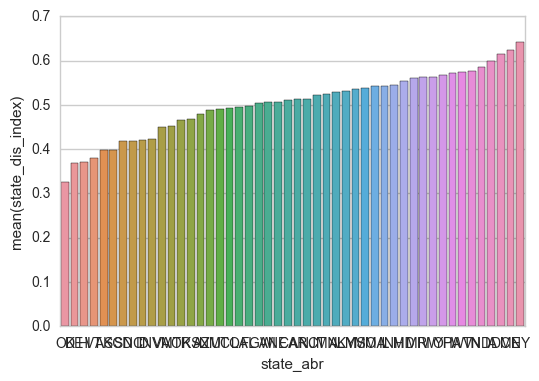

In [166]:
sns.set_style("whitegrid")
ax = sns.barplot(x='state_abr', y="state_dis_index", data=states_df.sort_values('state_dis_index'))

In [243]:
sorted_states_df = states_df.sort_values('state_dis_index')

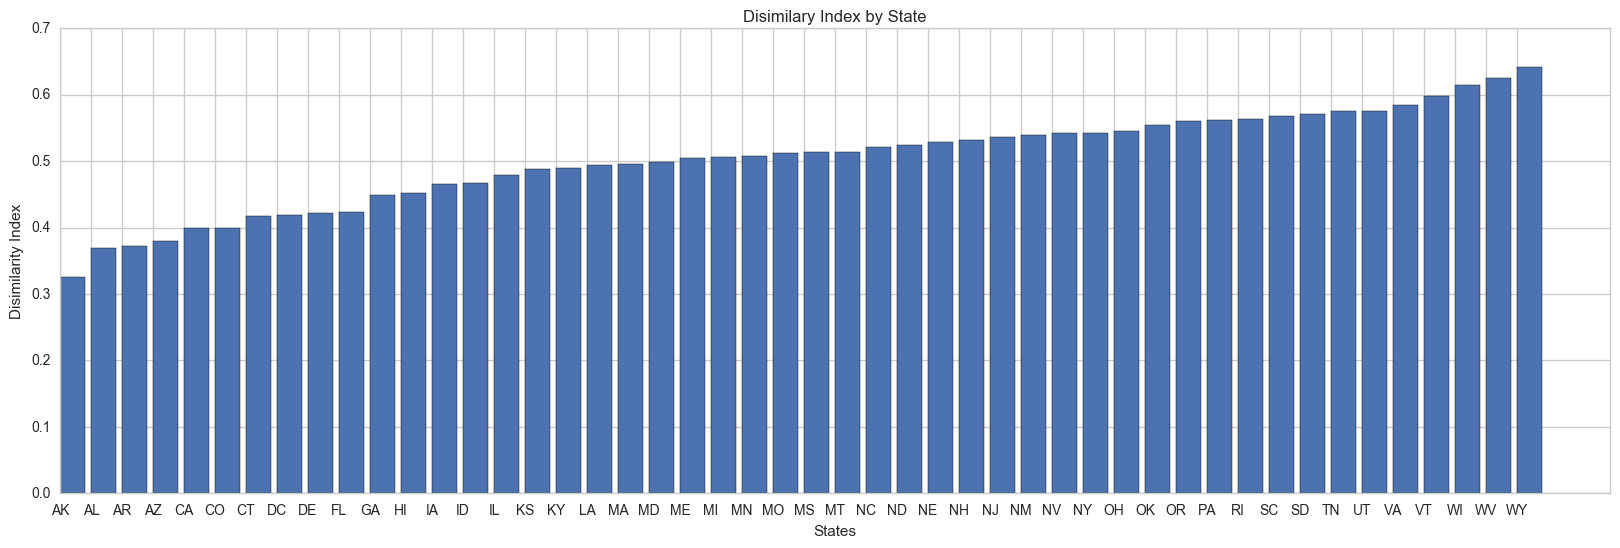

In [258]:
y_pos = np.arange(len(sorted_states_df["state_abr"]))
fig = plt.figure()
plt.figure(figsize=(20,6))
ind = np.arange(len(sorted_states_df["state_dis_index"]))
plt.bar(ind, sorted_states_df["state_dis_index"])
plt.ylabel('Disimilarity Index')
plt.xlabel('States')
plt.title('Disimilary Index by State')
plt.xticks(y_pos, states_df["state_abr"])
plt.show()

fig.autofmt_xdate()

# plt.savefig("figure.pdf")

TypeError: unorderable types: str() < int()

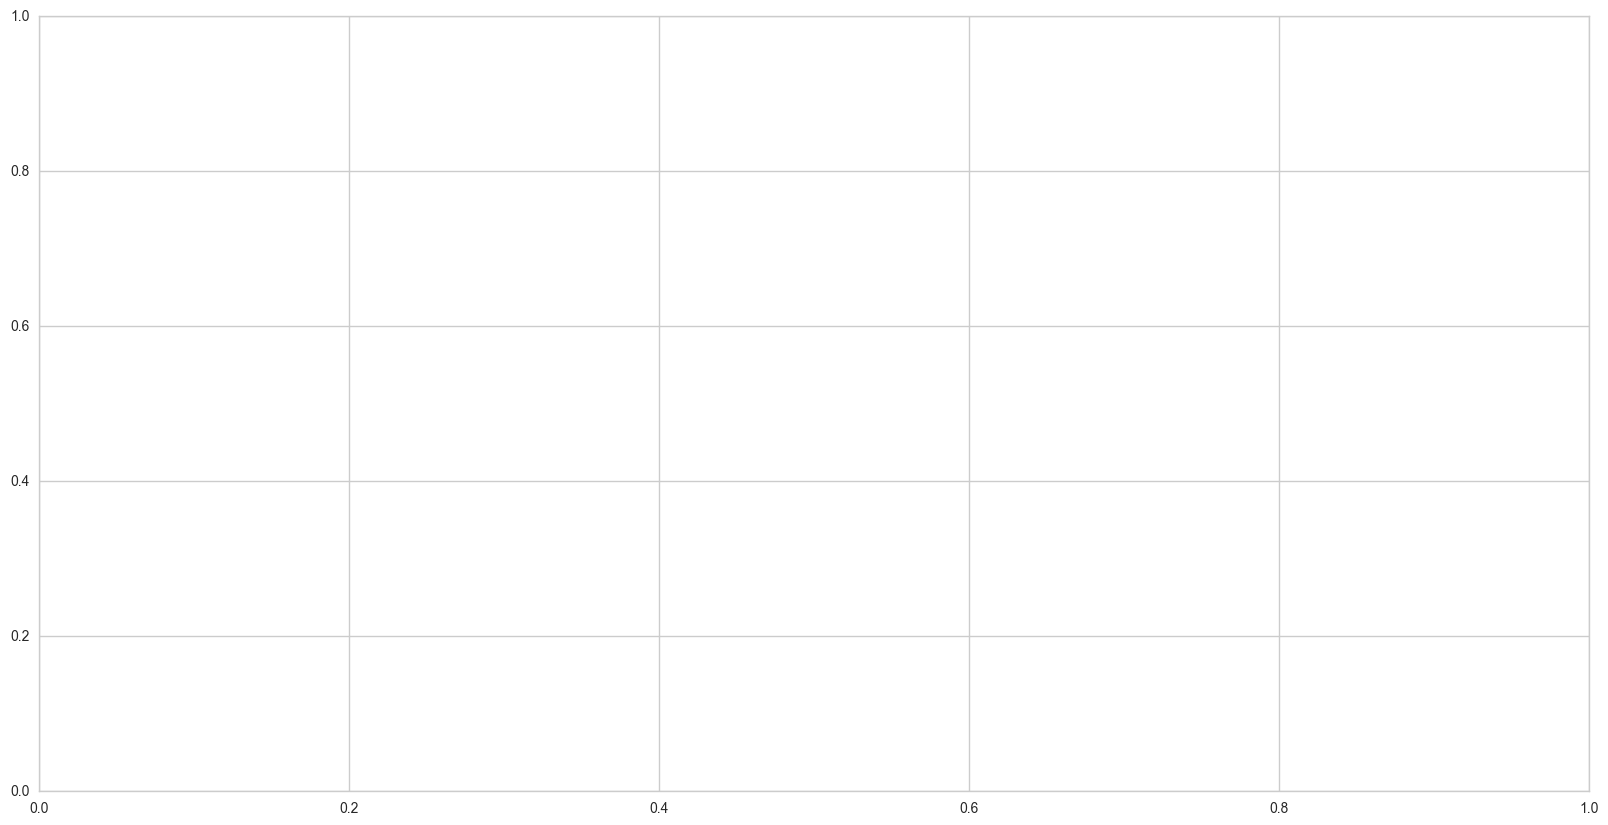

In [230]:
plt.figure(figsize=(20,10))
plt.bar(states_df["state_dis_index"], states_df['state_abr'], align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

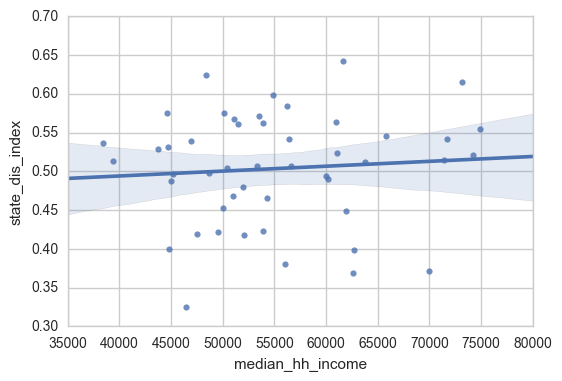

In [169]:
ax = sns.regplot(x='median_hh_income', y="state_dis_index", data=states_df)

In [168]:
states_df

,pupil_teacher_ratio,pct_under_18_in_poverty,median_hh_income,state_dis_index,state_abr,total_students_calc,white_students,black_students
0,15.005000,17.378947,62689.000000,0.398705,AK,13281.0,7316.0,872.0
1,17.539812,28.546948,43691.830986,0.529278,AL,160640.0,86435.0,61885.0
2,11.801228,32.130326,39338.285714,0.513153,AR,284248.0,172184.0,58116.0
3,19.090780,25.047666,51939.980344,0.479914,AZ,347215.0,168647.0,33223.0
4,25.631069,21.394163,63743.760463,0.511866,CA,1735237.0,525063.0,131691.0
5,17.759426,17.147826,59943.495274,0.493550,CO,486943.0,258551.0,67072.0
6,13.427595,14.070881,74259.134100,0.521629,CT,185844.0,107202.0,31326.0
7,16.744211,28.300000,73115.000000,0.615157,DC,8776.0,64.0,7830.0
8,14.993953,18.816279,62600.883721,0.368792,DE,42564.0,23440.0,10801.0
9,20.905602,23.916248,48660.664992,0.498321,FL,709537.0,310542.0,159185.0


In [170]:
### Create white vs minority bar plot

In [222]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18114 entries, 0 to 18113
Data columns (total 73 columns):
school_name                              18114 non-null object
state_name                               18114 non-null object
state                                    18114 non-null object
school_name_cl                           18114 non-null object
school_id                                18114 non-null object
agency_id                                18114 non-null object
county_name                              18114 non-null object
county_number                            18114 non-null object
fips_state_code                          18114 non-null object
school_level_code                        18114 non-null object
charter_school                           16700 non-null object
magnet_school                            13300 non-null object
shared_time_school                       15284 non-null object
urban_centric_locale                     18114 non-null object
start_of_

In [223]:
white_students = df['white_students'].sum()
print(white_students)
minority_students = df['total_students_calc'].sum() - df['white_students'].sum()
print(minority_students)

7527687.0
6706892.0


In [224]:
students_dict = {'white_students': ['White Students', white_students], 'minority_students': ['Minority Students', minority_students]}
total_students_df = pd.DataFrame.from_dict(students_dict, orient='index')

In [225]:
total_students_df.columns = ['type', 'total_students']
total_students_df

,type,total_students
minority_students,Minority Students,6706892.0
white_students,White Students,7527687.0


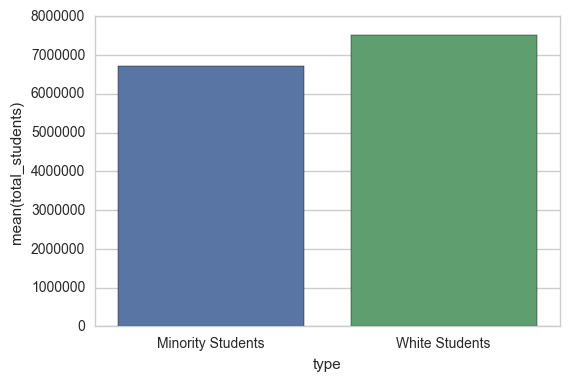

In [226]:
sns.barplot(x='type', y='total_students', data=total_students_df);